In [1]:
%load_ext autoreload
%autoreload 2
import numpy as np
import pandas as pd
import csv
import torch
cosmo_param_filename = '/network/scratch/t/tara.akhoundsadegh/camels_data/IllustrisTNG_LH_data/CosmoAstroSeed_IllustrisTNG.txt'
#cosmo_params = np.loadtxt(cosmo_param_filename, skiprows=1)
# Load file as CSV, skipping first column
cosmo_param_dict = {}
with open(cosmo_param_filename, newline='') as csvfile:
    reader = csv.DictReader(csvfile, delimiter=' ', skipinitialspace=True)
    for row in reader:
        cosmo_param_dict[row['#Name']] = row


/home/mila/d/daniel.levy/envs/cosmo/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# name of the file
fgrids = '/network/scratch/t/tara.akhoundsadegh/camels_data/CMD/Grids_Mtot_Nbody_IllustrisTNG_CV_128_z_0_0.npy'
# load the file
cmd_grids = np.load(fgrids)

# Take the first 3d grid
cmd_grid = cmd_grids[7]


In [3]:
import Pk_library as PKL
import MAS_library as MASL


In [74]:
from camels_dataset import CamelsDataset, CamelsDatasetRaw
path = '/network/scratch/t/tara.akhoundsadegh/camels_data/'
threshold=0.16
frac_val=0.0
#suite = 'IllustrisTNG' 
suite = 'SIMBA'
sim_set = 'CV'
#sim_set = 'LH'
dataset = CamelsDataset(path, threshold, suite, sim_set, debug=True)

nbody_raw_dataset = CamelsDatasetRaw(path, suite, sim_set, 'nbody')
hydro_raw_dataset = CamelsDatasetRaw(path, suite, sim_set, 'hydro')


Processing graphs...


100%|██████████| 27/27 [00:00<00:00, 164.79it/s]


In [75]:
nbody_raw = nbody_raw_dataset[7]
hydro_raw = hydro_raw_dataset[7]
data = dataset[7].ndata
nbody_matched = {'Pos': data['nbody_pos'].cpu().numpy(), 'Mass': data['nbody_mass'].squeeze().cpu().numpy()}
hydro_matched = {'Pos': data['hydro_pos'].cpu().numpy(), 'Mass': data['hydro_mass'].squeeze().cpu().numpy()}



## Plot histogram of masses for matched and unmatched

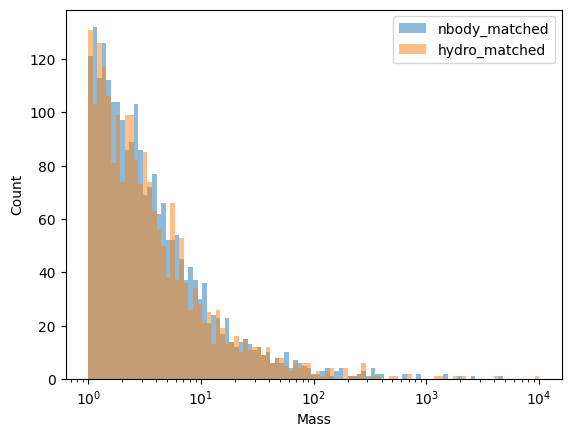

In [76]:
import matplotlib.pyplot as plt
plt.figure()
bins=10**np.linspace(0, 4, 100)
#plt.hist(nbody_raw['Mass'], bins=bins, alpha=0.5, label='nbody')
plt.hist(nbody_matched['Mass'], bins=bins, alpha=0.5, label='nbody_matched',)
#plt.hist(hydro_raw['Mass'], bins=bins, alpha=0.5, label='hydro')
plt.hist(hydro_matched['Mass'], bins=bins, alpha=0.5, label='hydro_matched')
plt.xscale('log')
plt.legend()
plt.xlabel("Mass")
plt.ylabel("Count")
plt.show()

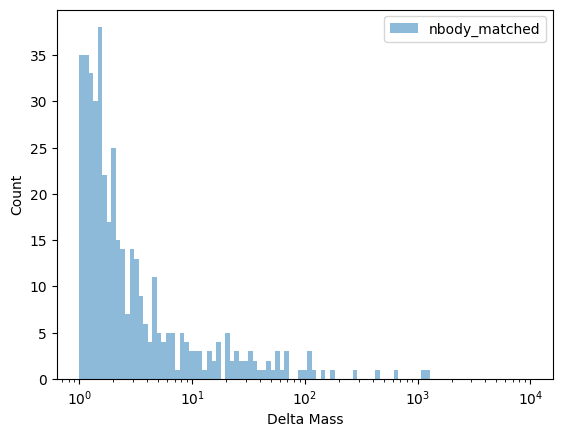

In [77]:
import matplotlib.pyplot as plt
plt.figure()
bins=10**np.linspace(0, 4, 100)
#plt.hist(nbody_raw['Mass'], bins=bins, alpha=0.5, label='nbody')
plt.hist(nbody_matched['Mass'] - hydro_matched['Mass'], bins=bins, alpha=0.5, label='nbody_matched',)
#plt.hist(hydro_raw['Mass'], bins=bins, alpha=0.5, label='hydro')

plt.xscale('log')
plt.legend()
plt.xlabel("Delta Mass")
plt.ylabel("Count")
plt.show()

## Compute Power Spectra

In [78]:
grid = 128
BoxSize = 25000 / 1e3
MAS = 'CIC'
overdensity = False
import smoothing_library as SL

R = 0.1
Filter = 'Gaussian'
threads = 1
W_k = SL.FT_filter(BoxSize, R, grid, Filter, threads)

def get_delta(pos, mass, grid, BoxSize, MAS, overdensity=True):
    delta = np.zeros((grid, grid, grid), dtype=np.float32)
    MASL.MA(BoxSize*pos, delta, BoxSize, MAS, W=mass*1e10, verbose=True)
    if overdensity:
        delta /= np.mean(delta)
        delta -= 1.
    return delta

delta_nbody_raw = get_delta(nbody_raw['Pos'], nbody_raw['Mass'], grid, BoxSize, MAS, overdensity)
delta_hydro_raw = get_delta(hydro_raw['Pos'], hydro_raw['Mass'], grid, BoxSize, MAS, overdensity)
delta_nbody_matched = get_delta(nbody_matched['Pos'], nbody_matched['Mass'], grid, BoxSize, MAS, overdensity)
delta_hydro_matched = get_delta(hydro_matched['Pos'], hydro_matched['Mass'], grid, BoxSize, MAS, overdensity)


field_smoothed = SL.field_smoothing(delta_nbody_raw, W_k, threads)



Using CIC mass assignment scheme with weights
Time taken = 0.001 seconds


Using CIC mass assignment scheme with weights
Time taken = 0.002 seconds


Using CIC mass assignment scheme with weights
Time taken = 0.000 seconds


Using CIC mass assignment scheme with weights
Time taken = 0.000 seconds



In [69]:
print(delta_nbody_raw.sum())
print(nbody_raw['Mass'].sum())
print(cmd_grid.sum()/1e10)

1127321700000000.0
112732.2
130099.6194041856


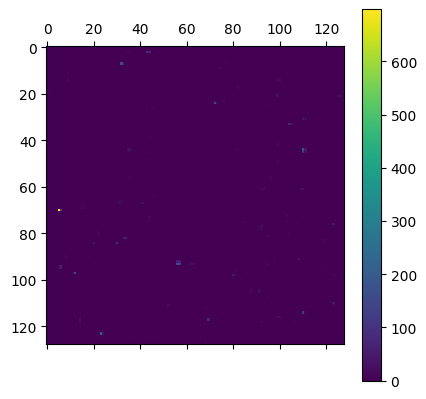

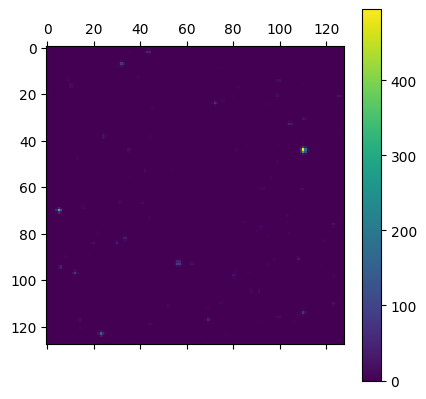

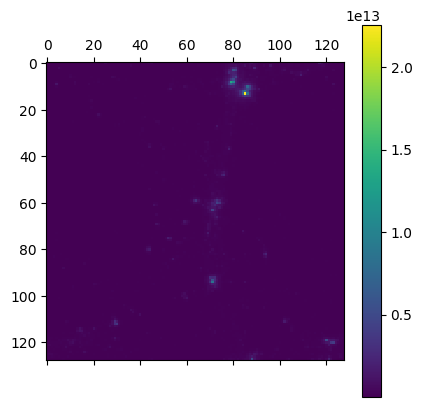

In [49]:
plt.matshow(delta_nbody_raw[0])
plt.colorbar()
plt.matshow(field_smoothed[0])
plt.colorbar()
plt.matshow(cmd_grid.sum(axis=2))
plt.colorbar()

In [50]:
delta_nbody_raw.shape

(128, 128, 128)

/tmp/ipykernel_20184/1212268508.py:1: RuntimeWarning: divide by zero encountered in log
  plt.matshow(np.log(delta_nbody_raw.mean(axis=2)))
/tmp/ipykernel_20184/1212268508.py:3: RuntimeWarning: divide by zero encountered in log
  plt.matshow(np.log(field_smoothed.mean(axis=2)))
/tmp/ipykernel_20184/1212268508.py:3: RuntimeWarning: invalid value encountered in log
  plt.matshow(np.log(field_smoothed.mean(axis=2)))


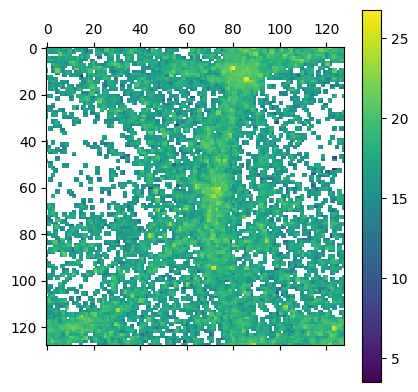

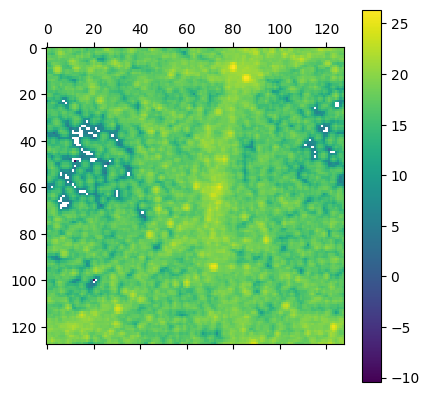

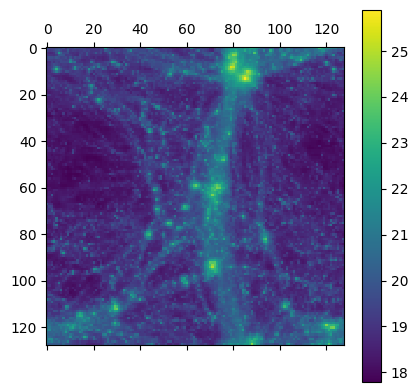

In [79]:
plt.matshow(np.log(delta_nbody_raw.mean(axis=2)))
plt.colorbar()
plt.matshow(np.log(field_smoothed.mean(axis=2)))
plt.colorbar()
plt.matshow(np.log(cmd_grid.mean(axis=2)))
plt.colorbar()

In [71]:

def get_power_spectra(delta, BoxSize):
    Pk = PKL.Pk(delta, BoxSize, axis=0, MAS='cic', threads=0, verbose=True)
    k_nbody = Pk.k3D
    pk0 = Pk.Pk[:,0] # Monopole
    #pk2 = Pk.Pk[:,2] # Quadrupole
    #pk4 = Pk.Pk[:,4] # Hexadecapole
    return k_nbody, pk0
cmd_grid_over_density = cmd_grid / np.mean(cmd_grid) - 1.
k_nbody_cmd, pk0_nbody_cmd = get_power_spectra(cmd_grid_over_density, BoxSize)
k_nbody_raw_smoothed, pk0_nbody_raw_smoothed = get_power_spectra(field_smoothed, BoxSize)
k_nbody_raw, pk0_nbody_raw = get_power_spectra(delta_nbody_raw, BoxSize)
k_hydro_raw, pk0_hydro_raw = get_power_spectra(delta_hydro_raw, BoxSize)
k_nbody_matched, pk0_nbody_matched = get_power_spectra(delta_nbody_matched, BoxSize)
k_hydro_matched, pk0_hydro_matched = get_power_spectra(delta_hydro_matched, BoxSize)




Computing power spectrum of the field...
Time to complete loop = 0.09
Time taken = 0.11 seconds

Computing power spectrum of the field...
Time to complete loop = 0.10
Time taken = 0.12 seconds

Computing power spectrum of the field...
Time to complete loop = 0.10
Time taken = 0.12 seconds

Computing power spectrum of the field...
Time to complete loop = 0.09
Time taken = 0.12 seconds

Computing power spectrum of the field...
Time to complete loop = 0.09
Time taken = 0.11 seconds

Computing power spectrum of the field...
Time to complete loop = 0.09
Time taken = 0.12 seconds


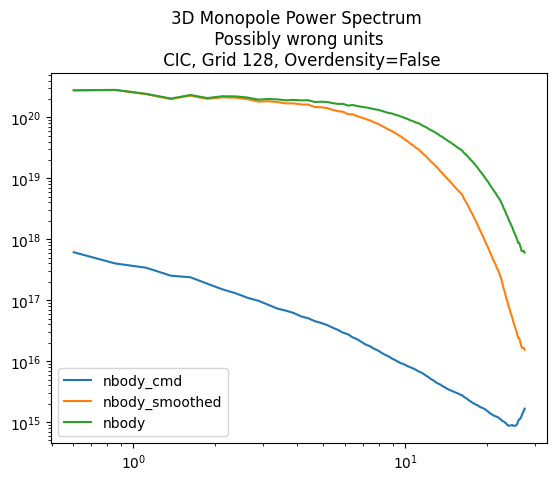

In [73]:
import matplotlib.pyplot as plt
plot_from = 1
plot_til = 1
plt.loglog(k_nbody_cmd[plot_from:-plot_til], 1e15*pk0_nbody_cmd[plot_from:-plot_til], label='nbody_cmd')

plt.loglog(k_nbody_raw_smoothed[plot_from:-plot_til], pk0_nbody_raw_smoothed[plot_from:-plot_til], label='nbody_smoothed')
plt.loglog(k_nbody_raw[plot_from:-plot_til], pk0_nbody_raw[plot_from:-plot_til], label='nbody')
#plt.loglog(k_hydro_raw[plot_from:-plot_til], pk0_hydro_raw[plot_from:-plot_til], label='hydro')
#plt.loglog(k_nbody_matched[plot_from:-plot_til], pk0_nbody_matched[plot_from:-plot_til], label='nbody_matched')
#plt.loglog(k_hydro_matched[plot_from:-plot_til], pk0_hydro_matched[plot_from:-plot_til], label='hydro_matched')
plt.title(f"3D Monopole Power Spectrum \n Possibly wrong units \n {MAS}, Grid {grid}, Overdensity={overdensity}")
plt.legend()

In [14]:
k_nbody = Pk_nbody.k1D
Pk1D_nbody = Pk_nbody.Pk1D
plt.plot(k_nbody, Pk1D_nbody, label='nbody')

k_hydro = Pk_hydro.k1D
Pk1D_hydro = Pk_hydro.Pk1D
plt.plot(k_hydro, Pk1D_hydro, label='hydro')

NameError: name 'Pk_nbody' is not defined